In [1]:
from google.colab import files
uploaded = files.upload()
# Data source https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv

Saving covid_19_data.csv to covid_19_data.csv


In [0]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['covid_19_data.csv']))

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = df.loc[df['Country/Region'] == "Germany"]

df.iloc[0]

SNo                          319
ObservationDate       01/28/2020
Province/State           Bavaria
Country/Region           Germany
Last Update        1/28/20 23:00
Confirmed                      4
Deaths                         0
Recovered                      0
Name: 318, dtype: object

In [35]:
len(df['Confirmed'].values )

95

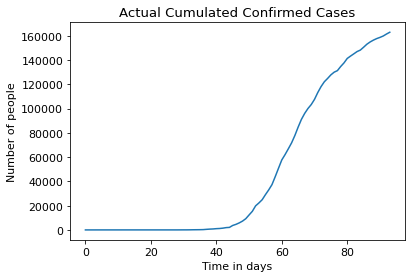

In [36]:
y=df['Confirmed'].values[0:94]

germany=plt.figure()
plt.rcParams.update({'font.size':11})
plt.plot(y, label="Actual Cases")
plt.xlabel("Time in days")
plt.ylabel("Number of people")
plt.title("Actual Cumulated Confirmed Cases")
germany.show()

germany.savefig('germany.png')
#files.download('germany.png')

In [0]:
def fit(x, a, b, c):
  #if a <= 0.0 or b<=0.0 or c<=0.0:return 1.0E10
  return a * np.exp(b * x) + c

In [0]:
#45 is optimal for south korea
y=df['Confirmed'].values[0:50]
x=np.arange(1,len(y)+1)

popt, pcov = curve_fit(fit, x, y)

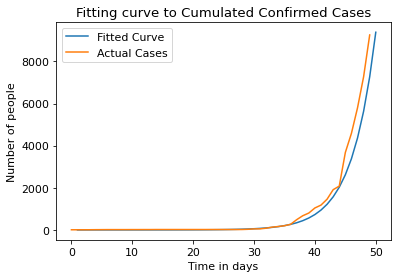

In [39]:
germany50=plt.figure()
plt.plot(x, fit(x, *popt), label="Fitted Curve")
plt.plot(y, label="Actual Cases")
plt.legend(loc="upper left")

plt.title("Fitting curve to Cumulated Confirmed Cases")
plt.xlabel('Time in days')
plt.ylabel('Number of people')
germany50.show()

germany50.savefig('ngermany50.pdf')
#files.download('ngermany50.pdf')

In [40]:
popt

array([ 0.02678395,  0.25534374, -2.85021947])

In [0]:
# Fixing v, n, f0
v = 1/7
n = 1/7
f0 = 0.8
X1 = popt[0]
X2 = popt[1]
X3 = -1 * popt[2]

In [0]:
S0 = 83000000                # Total population
# Germany 8.3 crores = 83000000 - 50d- 01/28/2020

import math

# calculating: t0, tao0, I0, U0, R0 
t0 = (math.log(X3/X1))/X2
I0 = X2*X3/f0*v
U0 = (1-f0)*v*I0/(n+X2)
tao0 = (X2+v)*(n+X2)/(S0*(n+X2+(1-f0)*v))

In [43]:
print(t0)
print(I0)
print(U0)
print(tao0)

18.278687673025516
0.1299617313833472
0.00932492241872003
4.4764125834988005e-09


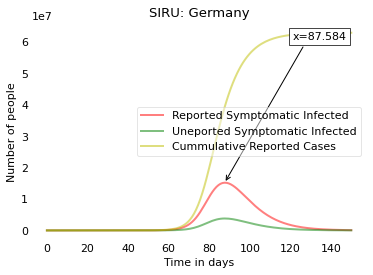

In [45]:
# Without public health intervention

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#S0 =           # Total population is susceptible initially
#I0 =                # Initial number of infected individuals, I0
R0 = 0              # Initial number of reported infectious individuals, R0.
#U0 =               # Initial number of unreported infectious individuals, U0.
CR0 = 0             # Cumulative reported infectious individuals at time t0, CR0.

#v =               # ......  rate
#n =             # Mean ...... rate (1/days)

Actual = df['Confirmed'].values            # Actual from data

t = np.linspace(0, 150, 150)      # A grid of time points (in days)
# linspace ( start, stop, number of entries in interval)

# The SIRU model differential equations.
def deriv(y, t, tao0, v, n, f0 ):
    S, I, R, U, CR = y
    dSdt = -tao0 * S * (I + U)                   # It means dS/dt
    dIdt =  tao0 * S * (I + U) - v * I
    dRdt = v * f0 * I - n * R
    dUdt = v * (1-f0) * I - n * U
    dCRdt = v * f0 * I
    return dSdt, dIdt, dRdt, dUdt, dCRdt

y0 = S0, I0, R0, U0, CR0                      # Initial conditions vector
# Integrate the SIR equations over the time grid, t.
# odeiRnt (model that returns dy/dt, y0, t)
ret = odeint(deriv, y0, t, args=(tao0, v, n, f0))
S, I, R, U, CR = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')

ax = fig.add_subplot(111, axisbelow=True)

#import pandas as pd
#date1 = '2019-11-01'
#date2 = '2020-04-08'
#t1 = pd.date_range(date1, date2).tolist()

# ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
# ax.plot(t, I 'y', alpha=0.5, lw=2, label='Asymptomatic Infected')
ax.plot(t, R, 'r', alpha=0.5, lw=2, label='Reported Symptomatic Infected')
ax.plot(t, U, 'g', alpha=0.5, lw=2, label='Uneported Symptomatic Infected')
ax.plot(t, CR, 'y', alpha=0.5, lw=2, label='Cummulative Reported Cases')
#ax.plot(t, Actual, 'b', alpha=0.5, lw=2, label='Actual Cummulative Reported Cases')

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}".format(xmax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(t,R)

ax.set_xlabel('Time in days')
ax.set_ylabel('Number of people')

#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.title("SIRU: Germany")
plt.show()

fig.savefig('SIRUwoMeasures.png')
files.download('SIRUwoMeasures.png')

In [0]:
tao0

4.4764125834988005e-09

In [0]:
 ## time t till no measures

y0 = S0, I0, R0, U0, CR0                      # Initial conditions vector
t= np.linspace(0,84,84)   
# Integrate the SIR equations over the time grid, t.
# odeiRnt (model that returns dy/dt, y0, t)
ret = odeint(deriv, y0, t, args=(tao0, v, n, f0))
S, I, R, U, CR = ret.T



In [0]:
y10 = S[-1], I[-1], R[-1], U[-1], CR[-1]
tao0=0
f0=0.9
t = np.linspace(0, 86, 86) 
ret1 = odeint(deriv, y10, t, args=(tao0, v, n, f0))
S1, I1, R1, U1, CR1 = ret1.T



In [0]:
#append S,I,R,U,CR with S1,I1,R1,U1,CR1
s = np.concatenate((S, S1))
i = np.concatenate((I, I1))
r = np.concatenate((R, R1))
u = np.concatenate((U, U1))
cr = np.concatenate((CR, CR1))


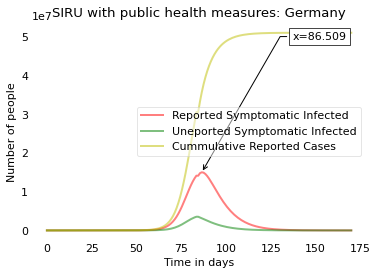

In [50]:
# t: added length
t = np.linspace(0, 170, 170)  

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')

ax = fig.add_subplot(111, axisbelow=True)

#ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
# ax.plot(t, I 'y', alpha=0.5, lw=2, label='Asymptomatic Infected')
ax.plot(t, r, 'r', alpha=0.5, lw=2, label='Reported Symptomatic Infected')
ax.plot(t, u, 'g', alpha=0.5, lw=2, label='Uneported Symptomatic Infected')
ax.plot(t, cr, 'y', alpha=0.5, lw=2, label='Cummulative Reported Cases')
#ax.plot(t, Actual, 'g', alpha=0.5, lw=2, label='Actual Cummulative Reported Cases')

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}".format(xmax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(t,r)

ax.set_xlabel('Time in days')
ax.set_ylabel('Number of people')

#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.title("SIRU with public health measures: Germany")
plt.rcParams.update({'font.size':11})
plt.show()

fig.savefig('SIRUwMeasures.png')
files.download('SIRUwMeasures.png')